In [1]:
from ase.optimize.ccqn0 import CCQNOptimizer
from ase.io import read, write
from ase.constraints import FixAtoms
from mace.calculators import MACECalculator

/root/miniforge3/envs/mace_les/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [ ]:
# -*- coding: utf-8 -*-
import os
import warnings
import time
import numpy as np
import torch


from ase.geometry import find_mic
from ase.optimize.optimize import Optimizer
from scipy.optimize import brentq 

# ==============================================================================
# JIT 编译核心：消除 Python 循环开销
# ==============================================================================

@torch.jit.script
def jit_solve_pgd(s: torch.Tensor, g: torch.Tensor, B: torch.Tensor, e_vec: torch.Tensor, 
                  delta: float, cos_phi: float, max_iter: int) -> torch.Tensor:
    """
    Uphill PGD 求解器的 JIT 编译版。
    完全在 GPU 上运行，没有 Python 循环开销。
    """
    lr = 0.01
    
    # 预先计算投影所需的标量常量 (在 GPU 上)
    target_proj = delta * cos_phi
    # sqrt(1 - cos^2)
    sin_phi = torch.sqrt(torch.tensor(1.0, device=s.device, dtype=s.dtype) - cos_phi**2)
    target_perp = delta * sin_phi
    
    # 这个循环现在是在 C++ 层面执行的
    for _ in range(max_iter):
        # 1. 梯度下降 (Gradient Descent)
        # s = s - lr * (g + B @ s)
        grad = g + B @ s
        s = s - lr * grad
        
        # 2. 球面投影 (Trust Region Projection)
        norm_s = torch.norm(s)
        if norm_s > 1e-9:
            s = s * (delta / norm_s)
        else:
            s = e_vec * delta
            
        # 3. 圆锥投影 (Cone Projection)
        proj_len = torch.dot(s, e_vec)
        
        # 如果投影长度小于目标长度 (说明跑出了圆锥)
        if proj_len < target_proj:
            s_par = proj_len * e_vec
            s_perp = s - s_par
            norm_perp = torch.norm(s_perp)
            
            if norm_perp > 1e-9:
                # 重新组合：固定平行分量 + 拉伸垂直分量以保持总长 delta
                s = (target_proj * e_vec) + (target_perp * (s_perp / norm_perp))
            else:
                # 垂直分量丢失的极端情况，重置为轴向量
                s = e_vec * delta
                
    return s

# ==============================================================================
# 优化器类定义
# ==============================================================================

class CCQNOptimizerGPU(Optimizer):
    """
    CCQN Optimizer V3.0 (JIT Accelerated).
    Features:
    - Pure GPU Hessian operations
    - JIT-compiled PGD solver (Zero Python Overhead)
    - Optimized PRFO interaction
    """
    def __init__(self, atoms, restart=None, logfile='-', trajectory=None, master=None,
                 e_vector_method='interp', product_atoms=None, reactive_bonds=None,
                 ic_mode='democratic', cos_phi=0.5, trust_radius_uphill=0.1, 
                 trust_radius_saddle_initial=0.05, hessian_update='ts-bfgs', 
                 idpp_images=7, use_idpp=False, hessian=False):
        super().__init__(atoms, restart, logfile, trajectory, master)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if self.logfile:
            self.logfile.write(f"CCQN-GPU V3.0 (JIT) initialized on device: {self.device}\n")

        # --- Parameters ---
        self.e_vector_method = e_vector_method
        self.hessian = hessian
        self.ic_mode = ic_mode.lower()
        self.product_atoms = product_atoms
        self.reactive_bonds = reactive_bonds
        self.idpp_images = idpp_images
        self.use_idpp = use_idpp 
        
        self.cos_phi = cos_phi
        self.trust_radius_uphill = trust_radius_uphill
        self.trust_radius_saddle_initial = trust_radius_saddle_initial
        self.trust_radius_saddle = self.trust_radius_saddle_initial
        self.trust_radius_saddle_max = 0.2
        self.trust_radius_saddle_min = 5e-3
        
        # --- Internal State (GPU) ---
        self.B = self._initialize_hessian() 
        self.mode = 'uphill'
        # 历史变量
        self.g_k_minus_1 = None   
        self.pos_k_minus_1 = None 
        self.energy_k_minus_1 = None
        self.rho = 0.0

    def _initialize_hessian(self):
        natoms = len(self.atoms)
        if self.hessian:
            h_np = self.atoms.calc.get_hessian(self.atoms).reshape(3 * natoms, 3 * natoms)
            return torch.from_numpy(h_np).to(self.device, dtype=torch.float64)
        # 初始化为对角阵，使用双精度
        return torch.eye(3 * natoms, device=self.device, dtype=torch.float64) * 70.0

    def step(self, f=None):
        if f is None: 
            f = self.atoms.get_forces()
        
        # 1. Load Data to GPU (Overhead here is unavoidable but minimal)
        g_k = torch.from_numpy(-f.flatten()).to(self.device, dtype=torch.float64)
        x_k_np = self.atoms.get_positions().flatten()
        x_k = torch.from_numpy(x_k_np).to(self.device, dtype=torch.float64)
        e_k = self.atoms.get_potential_energy()

        # 2. Hessian Update (TS-BFGS) - Pure GPU
        if self.nsteps > 0:
            s_k_prev = x_k - self.pos_k_minus_1
            y_k_prev = g_k - self.g_k_minus_1
            if torch.norm(s_k_prev) > 1e-7:
                self.B = self._update_hessian_ts_bfgs(self.B, s_k_prev, y_k_prev)

        # 3. Mode Selection - Pure GPU
        try:
            # eigh is fast on GPU
            eigvals, eigvecs = torch.linalg.eigh(self.B)
            min_eig = eigvals[0].item() # Sync point 1 (fast)
            
            if self.logfile: self.logfile.write(f"\nSmallest Eigval: {min_eig:.4e}")
            
            if self.mode == 'uphill':
                if min_eig < -1e-6:
                    self.mode = 'prfo'
                    self.trust_radius_saddle = self.trust_radius_saddle_initial
                    if self.logfile: self.logfile.write(" -> Switching to PRFO.\n")
            elif self.mode == 'prfo':
                if min_eig > 1e-2:
                    self.mode = 'uphill'
                    if self.logfile: self.logfile.write(" -> Switching to Uphill.\n")
        except RuntimeError:
            if self.logfile: self.logfile.write("Hessian diagonalization failed. Resetting.\n")
            self.B = self._initialize_hessian()
            eigvals, eigvecs = torch.linalg.eigh(self.B)
            self.mode = 'uphill'

        fmax = np.sqrt((f**2).sum(axis=1).max())
        if self.logfile:
            self.logfile.write(f"Step {self.nsteps:3d}: {self.mode.upper()}, E={e_k:.4f}, Fmax={fmax:.4f}, Trust={self.trust_radius_saddle:.4e}\n")

        # 4. Step Calculation
        s_k = None
        
        if self.mode == 'uphill':
            # e_vector calculation (CPU) - Fast enough for O(N)
            e_vec_np = self._calculate_e_vector_cpu()
            e_vec = torch.from_numpy(e_vec_np).to(self.device, dtype=torch.float64)
            
            # --- JIT Call (Critical Optimization) ---
            # Call the compiled function. Python loop overhead is gone.
            s_k = jit_solve_pgd(e_vec * self.trust_radius_uphill, # Initial guess s0
                                g_k, self.B, e_vec, 
                                float(self.trust_radius_uphill), 
                                float(self.cos_phi), 
                                200) # max_iter
        
        else: # PRFO Mode
            if self.nsteps > 0:
                s_k_prev = x_k - self.pos_k_minus_1
                s_norm_prev = torch.norm(s_k_prev).item() # Sync point 2

                # Matrix-vector products on GPU
                term2 = 0.5 * (s_k_prev @ (self.B @ s_k_prev))
                term1 = self.g_k_minus_1 @ s_k_prev
                pred_change = (term1 + term2).item()
                actual_change = e_k - self.energy_k_minus_1
                
                self.rho = self._calculate_rho(pred_change, actual_change)
                if self.logfile: self.logfile.write(f"  PRFO Quality: rho={self.rho:.4f}\n")
                
                self._update_saddle_trust_radius(self.rho, s_norm_prev)
            
            s_k = self._solve_prfo_step(g_k, eigvals, eigvecs)

        # 5. Apply Step (Transfer back to CPU for ASE)
        x_new_np = (x_k + s_k).cpu().numpy()
        self.atoms.set_positions(x_new_np.reshape(-1, 3))
        
        # 6. Store History (Keep on GPU)
        self.pos_k_minus_1 = x_k.clone()
        self.g_k_minus_1 = g_k.clone()
        self.energy_k_minus_1 = e_k

    # --- Solvers & Helpers ---

    def _solve_prfo_step(self, g, eigvals, eigvecs):
        tol = 1e-15
        
        # Matrix ops on GPU
        g_tilde = eigvecs.T @ g
        g_tilde_max, g_tilde_min = g_tilde[:1], g_tilde[1:]
        ev_max, ev_min = eigvals[:1], eigvals[1:]
        
        s_max = -torch.linalg.pinv(torch.diag(ev_max), rcond=tol) @ g_tilde_max
        s_min = -torch.linalg.pinv(torch.diag(ev_min), rcond=tol) @ g_tilde_min
        s_unc = eigvecs @ torch.cat([s_max, s_min])
        
        norm_s_unc = torch.norm(s_unc)
        if norm_s_unc <= self.trust_radius_saddle:
            return s_unc
            
        # Trust Region Scaling
        # We define residual to keep matrix ops on GPU
        def residual(a_sq):
            s1, _ = self._rfo_gpu(ev_max, g_tilde_max, 'max', a_sq)
            s2, _ = self._rfo_gpu(ev_min, g_tilde_min, 'min', a_sq)
            # Only transfer scalar result to CPU
            return (torch.sum(s1**2) + torch.sum(s2**2)).item() - self.trust_radius_saddle**2

        try:
            # Relaxed tolerance (1e-4) to reduce CPU-GPU interaction loops
            alpha_sq = brentq(residual, 1e-6, 1e6, xtol=1e-4)
            
            s1, _ = self._rfo_gpu(ev_max, g_tilde_max, 'max', alpha_sq)
            s2, _ = self._rfo_gpu(ev_min, g_tilde_min, 'min', alpha_sq)
            s = eigvecs @ torch.cat([s1, s2])
        except:
            if self.logfile: self.logfile.write("  Warning: Trust constraint failed, using scaling.\n")
            if norm_s_unc > tol:
                s = s_unc * (self.trust_radius_saddle / norm_s_unc)
            else:
                s = torch.zeros_like(g)

        s_norm_final = torch.norm(s)
        if s_norm_final > (self.trust_radius_saddle * 1.05):
            s *= (self.trust_radius_saddle / s_norm_final)
        return s

    def _rfo_gpu(self, lam, g, mode, a_sq):
        # GPU RFO Logic
        dim = len(lam)
        aug = torch.zeros((dim+1, dim+1), device=self.device, dtype=torch.float64)
        aug[:dim,:dim] = torch.diag(lam)
        a = np.sqrt(max(a_sq, 1e-15))
        aug[:dim, dim] = g/a
        aug[dim, :dim] = g/a
        
        vals, vecs = torch.linalg.eigh(aug)
        idx = -1 if mode == 'max' else 0
        scale = vecs[-1, idx]
        
        if abs(scale) < 1e-15:
            # Newton fallback on GPU
            s_newton = - (1.0 / lam) * g 
            s_newton = torch.nan_to_num(s_newton, 0.0)
            return s_newton, 0.0
        return (vecs[:dim, idx]/scale)*a, vals[idx]/2

    def _update_hessian_ts_bfgs(self, B, s, y):
        try:
            eigvals, eigvecs = torch.linalg.eigh(B)
            B_tilde = eigvecs @ (torch.diag(torch.abs(eigvals)) @ eigvecs.T)
        except RuntimeError:
            B_tilde = B
        
        M_k = torch.outer(y, y) + (s @ (B_tilde @ s)) * B_tilde
        j_k = y - (B @ s)
        sMs = s @ (M_k @ s)
        if abs(sMs) < 1e-12: return B
        
        u_k = (M_k @ s) / sMs
        jTs = j_k @ s
        delta_B = torch.outer(j_k, u_k) + torch.outer(u_k, j_k) - jTs * torch.outer(u_k, u_k)
        return B + delta_B

    def _calculate_rho(self, pred, actual):
        if abs(pred) < 1e-4: return 1.0 if abs(actual) < 1e-4 else 0.0
        return actual / pred

    def _update_saddle_trust_radius(self, rho, s_norm):
        rho_inc = 1.035
        rho_dec = 5.0      
        sigma_inc = np.sqrt(1.15)
        sigma_dec = np.sqrt(0.65)
        old = self.trust_radius_saddle
        
        if rho < 1.0/rho_dec or rho > rho_dec:
            self.trust_radius_saddle = max(self.trust_radius_saddle_min, old * sigma_dec)
        elif 1.0/rho_inc < rho < rho_inc:
            if abs(s_norm - old) < 1e-3:
                self.trust_radius_saddle = min(self.trust_radius_saddle_max, old * sigma_inc)

    def _calculate_e_vector_cpu(self):
        # CPU Geometric Logic (unchanged, strictly relying on ASE)
        if self.e_vector_method == 'ic':
             coords = self.atoms.get_positions()
             forces = self.atoms.get_forces()
             cell = self.atoms.get_cell()
             pbc = self.atoms.get_pbc()
             bonds = np.array(self.reactive_bonds, dtype=int)
             if len(bonds) == 0: return np.zeros(len(coords)*3)

             i_idx, j_idx = bonds[:,0], bonds[:,1]
             raw_v_ij = coords[j_idx] - coords[i_idx]
             v_ij, _ = find_mic(raw_v_ij, cell, pbc)
             norm_v = np.linalg.norm(v_ij, axis=1)
             valid = norm_v > 1e-8
             if not np.any(valid): return np.zeros(len(coords)*3)
             
             v_ij = v_ij[valid]; i_idx = i_idx[valid]; j_idx = j_idx[valid]
             f_i, f_j = forces[i_idx], forces[j_idx]
             dot_vj = np.sum(v_ij * f_j, axis=1)
             dot_vi = np.sum(v_ij * f_i, axis=1)
             dot_vv = np.sum(v_ij * v_ij, axis=1)
             p_ij_num = v_ij * (dot_vj/dot_vv)[:,None] - v_ij * (dot_vi/dot_vv)[:,None]
             
             E = np.zeros_like(coords)
             if self.ic_mode == 'democratic':
                 norm_p = np.linalg.norm(p_ij_num, axis=1)
                 valid2 = norm_p > 1e-8
                 if np.sum(valid2) > 0:
                     p_ij = p_ij_num[valid2] / norm_p[valid2][:,None]
                     np.add.at(E, i_idx[valid2], p_ij)
                     np.add.at(E, j_idx[valid2], -p_ij)
             else:
                 np.add.at(E, i_idx, p_ij_num)
                 np.add.at(E, j_idx, -p_ij_num)
                 
             e = E.flatten()
             n = np.linalg.norm(e)
             return e/n if n > 1e-8 else e
        return np.zeros(len(self.atoms)*3)

In [1]:
def ase_vib(ts_atoms, name, constraint, CUTOFF=50, calc=None):
    from ase.vibrations import Vibrations
    from ase.constraints import FixAtoms
    from ase import units
    import ase
    os.system("rm -rf ./vib")   
    os.system("rm -rf {name}")
    TS = ts_atoms.copy()
    TS.calc = calc
    #constraint = FixAtoms(indices=[i for i in range(len(TS)) if TS[i].symbol  in ["Pd", "Ag"]])
    if constraint is not None:
        TS.set_constraint(constraint)
    vib = Vibrations(TS, name=name)
    vib.run()
    #vib.summary()
    all_frequencies = vib.get_frequencies()

    # 2. 找到虚频的索引
    # 虚频的虚部大于一个很小的阈值 (避免浮点误差)
    imag_indices = np.where(all_frequencies.imag > CUTOFF)[0]

    # 3. 获取虚频的数量
    num_imag_freqs = len(imag_indices)
    print(f"找到的虚频数量: {num_imag_freqs}")

    # 4. 获取虚频的值
    # 惯例上，虚频的值被报道为其虚部的大小 (一个正实数)
    if num_imag_freqs > 0:
        imag_freq_values = all_frequencies[imag_indices].imag
        print("虚频的值 (cm^-1):")
        for i, freq_val in zip(imag_indices, imag_freq_values):
            print(f"  模式 #{i}: {freq_val:.2f}i cm^-1")

    # 5. 获取虚频对应的振动模式
    if num_imag_freqs > 0:
        print("\n获取虚频对应的振动模式:")
        imag_modes = {}
        for index in imag_indices:
            # 使用 get_mode(n) 方法获取第n个模式
            # 返回一个 (N, 3) 的numpy数组, N是原子数
            mode_vector = vib.get_mode(index)
            imag_modes[index] = mode_vector
            print(f"  模式 #{index} 的振动矢量 (displacement vector):")
            # print(mode_vector) # 如果需要，可以取消注释打印完整的矢量

            # 你也可以将这个模式写入文件进行可视化
            output_xyz_file = f'{vib.name}.{index % len(vib.get_energies())}.xyz'

            # 3. 使用 iter_animated_mode 生成器创建动画帧
            #    这个生成器会产生一系列 Atoms 对象，代表原子在一个振动周期内的运动
            images_generator = vib.get_vibrations().iter_animated_mode(
                index,
                temperature=units.kB * 300,  # 振幅参数，同 write_mode 默认值
                frames=30                    # 动画帧数，同 write_mode 默认值
            )

            # 4. 使用 ase.io.write 将所有帧写入一个多帧 xyz 文件
            #    ase.io.write 会自动识别 .xyz 后缀并使用正确的格式
            images_list = list(images_generator)
            ase.io.write(output_xyz_file, images_list)
            vib.clean()
            print(f"振动模式 {index} 的动画已成功写入到文件: {output_xyz_file}")
    return num_imag_freqs


import os
from ase.io import read, write
from ase.io.trajectory import Trajectory
from sella import IRC

def get_clean_irc_path(ts_atoms, irc_log_prefix="irc", fmax=0.05, steps=1000, dx=0.1, eta=1e-4, ninner_iter=100):
    """
    Runs forward and reverse IRC calculations from a transition state (TS),
    and returns a clean, correctly ordered reaction path without duplicates.

    This approach is more robust because it separates the two IRC directions
    into different files and splices them structurally, avoiding complex and
    brittle energy filtering.

    Args:
        ts_atoms (ase.Atoms): The transition state structure with a calculator attached.
        irc_log_prefix (str): A prefix for the trajectory log files. Can include a path.
        fmax (float): The force convergence criterion for the IRC run.
        steps (int): The maximum number of steps for each IRC direction.
        dx (float): The initial step size for the IRC algorithm.
        eta (float): A parameter for the IRC algorithm.

    Returns:
        list: A list of ase.Atoms objects representing the full, clean reaction path
              from reactant to product. Returns None if a path cannot be formed.
    """
    # 1. 定义清晰的文件名
    forward_traj_file = f"{irc_log_prefix}_forward.traj"
    reverse_traj_file = f"{irc_log_prefix}_reverse.traj"

    # --- FIX: Ensure the output directory exists before writing ---
    # This handles cases where irc_log_prefix includes a path like "results/my_reaction"
    output_dir = os.path.dirname(irc_log_prefix)
    if output_dir:  # Only run if a directory path is part of the prefix
        os.makedirs(output_dir, exist_ok=True)

    # 2. 分别运行正向和反向IRC，并保存到独立文件
    # --- 正向路径 (TS -> Product) ---
    print(f"Running IRC forward, saving to {forward_traj_file}...")
    TS = ts_atoms.copy()
    TS.calc = ts_atoms.calc
    irc_forward = IRC(TS, trajectory=forward_traj_file, dx=dx, eta=eta, ninner_iter=ninner_iter, logfile=f"{irc_log_prefix}_forward.log")
    irc_forward.run(fmax=fmax, steps=steps, direction='forward')

    # --- 反向路径 (TS -> Reactant) ---
    print(f"Running IRC reverse, saving to {reverse_traj_file}...")
    TS = ts_atoms.copy()
    TS.calc = ts_atoms.calc
    irc_reverse = IRC(TS, trajectory=reverse_traj_file, dx=dx, eta=eta, ninner_iter=ninner_iter, logfile=f"{irc_log_prefix}_reverse.log")
    irc_reverse.run(fmax=fmax, steps=steps, direction='reverse')

    # 3. 从独立文件中读取路径
    forward_path = read(forward_traj_file, index=":")
    reverse_path = read(reverse_traj_file, index=":")

    # 检查路径是否有效
    if not forward_path or not reverse_path:
        print("Error: One or both IRC calculations failed to produce a path.")
        return None

    # 4. 结构化地拼接路径 (最关键的一步)
    # reverse_path 的顺序是 [TS, rev1, rev2, ... -> Reactant]
    # 我们需要将其反转，得到 [Reactant -> ..., rev2, rev1, TS]
    reverse_path.reverse()

    # forward_path 的顺序是 [TS, fwd1, fwd2, ... -> Product]
    # 为避免TS重复，我们只取 forward_path 中除第一个元素外的所有元素
    
    # 最终路径 = (从反应物到过渡态) + (从过渡态到产物)
    # 这个拼接方法从根本上保证了路径的连续性和TS的唯一性
    full_path = reverse_path + forward_path[1:]
    
    print(f"Successfully generated a clean path with {len(full_path)} images.")
    
    return full_path


import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

def mass_weighted_path(traj):
    """计算质量加权的反应路径长度 (IRC reaction coordinate)."""
    masses = traj[0].get_masses()
    s = [0.0]
    for i in range(1, len(traj)):
        dr = traj[i].positions - traj[i-1].positions
        step = np.sqrt((masses[:, None] * dr**2).sum())
        s.append(s[-1] + step)
    return np.array(s)

def combine_irc(reverse_traj, forward_traj):
    """
    拼接 reverse + forward IRC 轨迹
    - reverse_path: [TS -> Reactant]
    - forward_path: [TS -> Product]
    拼接后: [Reactant -> ... -> TS -> ... -> Product]
    """
    reverse = read(reverse_traj, ":")
    forward = read(forward_traj, ":")

    if not reverse or not forward:
        raise RuntimeError("Error: One of the IRC trajectories is empty.")

    # 反向轨迹需要翻转，形成 Reactant -> TS
    reverse.reverse()

    # 避免 TS 重复：去掉 forward 的第一个结构
    full = reverse + forward[1:]

    return full

def plot_irc(full_traj, title="IRC Path"):
    energies = np.array([atoms.get_potential_energy() for atoms in full_traj])
    s = mass_weighted_path(full_traj)

    # 归一化能量
    energies -= energies.min()

    plt.figure(figsize=(6,4))
    plt.plot(s, energies, "o-", color="C0")
    plt.xlabel("Reaction coordinate (mass-weighted, Å·sqrt(u))")
    plt.ylabel("Energy (eV, relative)")
    context = f"delta_E = {energies[-1] - energies[0]:.4f} eV, barrier = {np.max(energies) - energies[0]:.4f} eV, reverse barrier = {np.max(energies) - energies[-1]:.4f} eV"
    plt.title(context)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{title}.png", dpi=300)
    write(f"IRC_{title}.xyz", full_traj)





In [17]:
import os

os.chdir("/mnt/c/Users/user/Downloads/xtb")
import os
import shutil
import numpy as np
from ase.vibrations import Vibrations
from ase import units


from ase.calculators.singlepoint import SinglePointCalculator
import os
import shutil
import numpy as np
from ase.vibrations import Vibrations
from ase import units
from ase.io import write # 导入用于写入文件的模块

# 定义一个辅助函数来处理动画输出，避免代码重复
def write_animated_mode_xyz(vib_object, atoms, index, file_prefix, is_imag):
    """
    使用 iter_animated_mode 和 ase.io.write 生成多帧 XYZ 动画文件。
    该函数假定您的 ASE 版本不支持 iter_animated_mode 的关键字参数。
    """
    # 构造输出文件名: [file_prefix].[index].xyz
    # 确保文件写入到正确的目录下，并遵循ASE的命名约定
    
    # 1. 获取振动模式的动画帧生成器
    # 注意: 为了兼容性，不使用 temperature/frames 关键字参数
    # 如果您的环境支持，您可以加上 temperature=units.kB * 300, frames=30
    try:
        images_generator = vib_object.get_vibrations().iter_animated_mode(
            index,
            # 移除以下关键字参数以避免 TypeError:
            # temperature=units.kB * 300,  
            # frames=30                   
        )
    except Exception as e:
        print(f"     [Error] 无法创建模式 #{index} 的动画生成器。可能参数不兼容。错误: {e}")
        return

    # 2. 将生成器转换为 Atoms 对象列表
    try:
        images_list = list(images_generator)
    except Exception as e:
        print(f"     [Error] 无法将动画生成器转换为列表。错误: {e}")
        return

    # 3. 写入多帧 XYZ 文件
    tag = "imag" if is_imag else "real"
    # 使用 vib_object.name 作为目录和文件前缀
    output_filename = os.path.join(vib_object.name, f'{file_prefix}.{index}.{tag}.xyz')
    
    if not os.path.exists(vib_object.name):
        os.makedirs(vib_object.name)
        
    write(output_filename, images_list)
    
    print(f"     > Animation for Mode #{index} output to {output_filename}")


def get_vib_mode(ts_atoms, constraint=None, name='vib_check', cutoff_cm=50.0, 
                 output_all_imag_modes=False, output_all_real_modes=False):
    """
    [XYZ 输出版] 检查一阶鞍点，并根据选项提取虚频模式和振动动画 (.xyz)。

    参数:
        ts_atoms (ase.Atoms): 结构。
        constraint (ase.constraints.Constraint): 约束。
        name (str): 振动分析输出文件的目录名/前缀。
        cutoff_cm (float): 虚频的截止频率 (cm^-1)。低于此值被认为是噪音。
        output_all_imag_modes (bool): 
            如果为 True，则所有超过截止频率的虚频（即使多于一个）都会输出动画。
        output_all_real_modes (bool): 
            如果为 True，则所有实频的本征向量也会输出动画。

    返回:
        numpy.ndarray 或 None: 如果找到唯一的显著虚频，则返回其本征向量。
                               否则返回 None。
    """
    # 1. 环境清理
    if os.path.exists(name): shutil.rmtree(name)
    if os.path.exists("vib"): shutil.rmtree("vib")

    print(f"\n>>> [Vib-Check] Starting Hessian calculation for {name}...")
    
    atoms_vib = ts_atoms.copy()
    atoms_vib.calc = ts_atoms.calc
    
    #if constraint is not None:
    atoms_vib.set_constraint(constraint)
    print(f"     Constraint {constraint} applied.")

    # 2. 运行振动分析
    vib = Vibrations(atoms_vib, name=name) 
    vib.run()
    
    # 3. 分析频率
    energies = vib.get_energies() # 使用 energies 进行更健壮的虚频判断
    
    imag_candidates = []
    real_modes_to_output = []
    print(f">>> [Vib-Check] Frequency Analysis (Cutoff = {cutoff_cm} cm^-1):")
    
    for i, e in enumerate(energies):
        if e.imag > 0:
            freq_val = abs(e) / units.invcm 
            
            if freq_val > cutoff_cm:
                mode_vec = vib.get_mode(i)
                print(f"     [!] Found Imaginary Mode #{i}: {freq_val:.2f}i cm^-1")
                imag_candidates.append((i, freq_val, mode_vec))
                
                # 如果开启了输出所有虚频，则调用 XYZ 输出函数
                if output_all_imag_modes:
                    write_animated_mode_xyz(vib, atoms_vib, i, name, is_imag=True)
            else:
                print(f"     [Ignored] Noise Imaginary Mode #{i}: {freq_val:.2f}i cm^-1")
        
        elif output_all_real_modes and e.real > 0:
            freq_val = e.real / units.invcm
            print(f"     [Real] Mode #{i}: {freq_val:.2f} cm^-1")
            real_modes_to_output.append(i)

    # 4. 鞍点逻辑判断 & 唯一的虚频 XYZ 输出 
    num_imag = len(imag_candidates)
    result_vec = None
    
    print("\n" + "-"*30)
    
    if num_imag == 0:
        print(">>> [Result] No significant imaginary frequencies found. (MINIMUM)")
    
    elif num_imag == 1:
        idx, val, vec = imag_candidates[0]
        print(">>> [Result] Confirmed First-Order Saddle Point.")
        print(f"     Reaction Coordinate: Mode #{idx} ({val:.1f}i cm^-1)")
        
        # 如果 output_all_imag_modes=False，则在这里输出唯一的虚频动画
        if not output_all_imag_modes:
             write_animated_mode_xyz(vib, atoms_vib, idx, name, is_imag=True)
        
        result_vec = vec
        
    elif num_imag > 1:
        print(f">>> [Result] Higher-Order Saddle Point found ({num_imag} modes).")
        for idx, val, _ in imag_candidates:
            print(f"     Mode {idx}: {val:.1f}i")
        
        if not output_all_imag_modes:
            print("     > No imaginary mode animations output (set output_all_imag_modes=True to output all).")


    # 5. 实频 XYZ 动画输出
    if output_all_real_modes:
        print("\n>>> [Output] Generating animations for all real modes...")
        for i in real_modes_to_output:
            write_animated_mode_xyz(vib, atoms_vib, i, name, is_imag=False)
            
    # 6. 清理和返回
    vib.clean()
    print("------------------------------")
    
    return result_vec


from ase.io import read, write
from ase.optimize import LBFGS, FIRE

class TSDescentOptimizer:
    """
    Fake-IRC Optimizer: 沿着给定的虚频方向进行双向几何优化。
    """
    def __init__(self, ts_atoms, vib_mode, constraint=None, delta=0.1, log_prefix="descent"):
        self.ts_atoms = ts_atoms
        # 确保优化过程中也应用同样的约束
        #if constraint is not None:
        self.ts_atoms.set_constraint(constraint)
            
        self.vib_mode = self._normalize_mode(vib_mode)
        self.delta = delta
        self.log_prefix = log_prefix
        self.full_path = []

    def _normalize_mode(self, mode):
        norm = np.linalg.norm(mode)
        return mode / norm if norm > 1e-6 else mode

    def run(self, fmax=0.05, steps=200, optimizer_cls=FIRE):
        # 1. Forward
        print(f"\n>>> [Descent] Forward Optimization (+{self.delta})...")
        atoms_fwd = self.ts_atoms.copy()
        atoms_fwd.calc = self.ts_atoms.calc
        atoms_fwd.set_positions(self.ts_atoms.get_positions() + self.delta * self.vib_mode)
        
        opt_fwd = optimizer_cls(atoms_fwd, trajectory=f"{self.log_prefix}_fwd.traj", logfile=f"{self.log_prefix}_fwd.log")
        opt_fwd.run(fmax=fmax, steps=steps)
        path_fwd = read(f"{self.log_prefix}_fwd.traj", index=':')

        # 2. Reverse
        print(f"\n>>> [Descent] Reverse Optimization (-{self.delta})...")
        atoms_rev = self.ts_atoms.copy()
        atoms_rev.calc = self.ts_atoms.calc
        atoms_rev.set_positions(self.ts_atoms.get_positions() - self.delta * self.vib_mode)
        
        opt_rev = optimizer_cls(atoms_rev, trajectory=f"{self.log_prefix}_rev.traj", logfile=f"{self.log_prefix}_rev.log")
        opt_rev.run(fmax=fmax, steps=steps)
        path_rev = read(f"{self.log_prefix}_rev.traj", index=':')

        # 3. Combine
        ts_snap = self.ts_atoms.copy()

        ts_snap.calc = SinglePointCalculator(
            ts_snap, 
            energy=self.ts_atoms.get_potential_energy(),
            forces=self.ts_atoms.get_forces()
        )
        self.full_path = path_rev[::-1] + [ts_snap] + path_fwd
        write(f"{self.log_prefix}_full.traj", self.full_path)
        write(f"{self.log_prefix}_full.xyz", self.full_path)
        print(f">>> [Descent] Done. Full path length: {len(self.full_path)}")
        
        return self.full_path

import matplotlib.pyplot as plt
import numpy as np

def plot_descent_profile(full_path, title="Reaction_Profile", save_path=None):
    """
    绘制 Fake-IRC 路径的能量曲线。
    
    Args:
        full_path (list[Atoms]): TSDescentOptimizer.run() 返回的完整路径列表。
        title (str): 图表标题。
        save_path (str): 如果不为 None，则保存图片到该路径 (e.g., "profile.png")。
    """
    if not full_path or len(full_path) < 3:
        print("Path too short to plot.")
        return

    # 1. 提取能量
    # 注意：确保所有 atoms 都有 calculator 或者 info['energy']
    # 如果是刚跑完的，通常都有 get_potential_energy()
    try:
        energies = np.array([atoms.get_potential_energy() for atoms in full_path])
    except Exception as e:
        print(f"Error getting energies: {e}")
        return

    # 2. 计算横坐标 (累积几何距离)
    # 相比于简单的 index，这样更能反映真实的几何变化幅度
    dist = [0.0]
    for i in range(1, len(full_path)):
        # 计算相邻两帧的 RMSD 或 欧几里得距离
        d = np.linalg.norm(full_path[i].positions - full_path[i-1].positions)
        dist.append(dist[-1] + d)
    dist = np.array(dist)

    # 3. 数据处理
    # 找到能量最高的点作为 TS
    ts_idx = np.argmax(energies)
    
    # 以反应物 (起点) 为能量零点
    base_energy = energies[0]
    rel_energies = energies - base_energy
    
    # 关键数据
    E_barrier_fwd = rel_energies[ts_idx] # 正向能垒
    E_reaction = rel_energies[-1]        # 反应热 (Delta E)
    E_barrier_rev = rel_energies[ts_idx] - rel_energies[-1] # 逆向能垒

    # 4. 绘图
    plt.figure(figsize=(8, 5))
    
    # 绘制曲线
    plt.plot(dist, rel_energies, 'o-', color='tab:blue', markersize=4, linewidth=1.5, label='Path')
    
    # 标记特殊点
    # IS (Start)
    plt.scatter(dist[0], rel_energies[0], color='green', s=100, label='IS', zorder=5)
    # FS (End)
    plt.scatter(dist[-1], rel_energies[-1], color='orange', s=100, label='FS', zorder=5)
    # TS (Max)
    plt.scatter(dist[ts_idx], rel_energies[ts_idx], color='red', marker='*', s=200, label='TS', zorder=5)

    # 添加文字标注
    plt.text(dist[ts_idx], rel_energies[ts_idx] + 0.05, f"$E_a={E_barrier_fwd:.2f}$ eV", 
             ha='center', va='bottom', fontsize=12, color='red', fontweight='bold')
    
    plt.text(dist[-1], rel_energies[-1] - 0.1, f"$\Delta E={E_reaction:.2f}$ eV", 
             ha='right', va='top', fontsize=10, color='orange')

    # 装饰
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    plt.xlabel("Cumulative Distance ($\AA$)")
    plt.ylabel("Relative Energy (eV)")
    plt.title(f"{title}\nForward Barrier: {E_barrier_fwd:.3f} eV | Reverse: {E_barrier_rev:.3f} eV")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to: {save_path}")
    
    plt.show()


<>:290: SyntaxWarning: invalid escape sequence '\D'
<>:295: SyntaxWarning: invalid escape sequence '\A'
<>:290: SyntaxWarning: invalid escape sequence '\D'
<>:295: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_13713/3767304846.py:290: SyntaxWarning: invalid escape sequence '\D'
  plt.text(dist[-1], rel_energies[-1] - 0.1, f"$\Delta E={E_reaction:.2f}$ eV",
/tmp/ipykernel_13713/3767304846.py:295: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Cumulative Distance ($\AA$)")


In [1]:
import sys
import os

# 将项目根目录加入 path
project_root = "/mnt/d/Download/trae-research-code/open-ts-search"
if project_root not in sys.path:
    sys.path.append(project_root)

# 现在可以正常导入了
from algo.ccqn.ccqn_optimizer import CCQNOptimizer
from algo.ccqn.ccqn_optimizer_gpu import CCQNGPUOptimizer

In [1]:
import sys
import os
# 將 mace 项目根目錄加入系統路徑

project_root = "/mnt/d/Download/trae-research-code/mace"
if project_root not in sys.path:
    sys.path.append(project_root)


import mace
from mace.calculators import MACECalculator
from ase.io import read
from mace.calculators.batch_neb import BatchNEB
from ase.optimize import FIRE
from ase.mep import NEB
from mace.calculators.batch_neb_scheduler import BatchNEBScheduler

/root/miniforge3/envs/mace_les/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
images1 = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Homo.cif', index=":")
images2 = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Hete.cif', index=":")
calc = MACECalculator(model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model', device='cuda')

neb1 = BatchNEB(images1, calc, k=0.1)
neb2 = BatchNEB(images2, calc, k=0.1) # 也可以是標準 ASE NEB

# 定義各自的優化器
opt1 = FIRE(neb1)
opt2 = FIRE(neb2)

# 使用 Scheduler 統一運行
scheduler = BatchNEBScheduler(
    nebs_and_optimizers=[(neb1, opt1), (neb2, opt2)],
    calculator=calc, # 共用的 MACE Calculator
    device='cuda',
    batch_logfile="-",
    max_edges_per_batch=200000
)

# 開始同步優化
scheduler.run(fmax=0.05, steps=1000)

/mnt/d/Download/trae-research-code/mace/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


# BatchNEBScheduler: Computing forces for 14 images (Total 1610 atoms) in a single global batch. [GraphBuild: 0.031s, Batch: 0.006s]
# BatchNEBScheduler: Computing forces for 14 images (Total 1610 atoms) in a single global batch. [GraphBuild: 0.031s, Batch: 0.006s]
# BatchNEBScheduler: Computing forces for 14 images (Total 1610 atoms) in a single global batch. [GraphBuild: 0.031s, Batch: 0.006s]
# BatchNEBScheduler: Computing forces for 10 images (Total 1150 atoms) in a single global batch. [GraphBuild: 0.021s, Batch: 0.005s]
# BatchNEBScheduler: Computing forces for 10 images (Total 1150 atoms) in a single global batch. [GraphBuild: 0.021s, Batch: 0.005s]
# BatchNEBScheduler: Computing forces for 10 images (Total 1150 atoms) in a single global batch. [GraphBuild: 0.021s, Batch: 0.005s]
# BatchNEBScheduler: Computing forces for 10 images (Total 1150 atoms) in a single global batch. [GraphBuild: 0.021s, Batch: 0.004s]
# BatchNEBScheduler: Computing forces for 10 images (Total 1150 atoms

KeyboardInterrupt: 

In [2]:
# 準備 Images 與 Calculator
images = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Hete.cif', index=":")
calc = MACECalculator(model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model', device='cuda')
'''for image in images:
    calc = MACECalculator(model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model', device='cuda')
    image.set_calculator(calc)'''
# 使用 BatchNEB 取代標準 NEB
neb = BatchNEB(images, calc, k=0.1, climb=True, batch_logfile="-")

# 像平常一樣跑優化
opt = FIRE(neb)
opt.run(fmax=0.05)

/mnt/d/Download/trae-research-code/mace/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


# BatchNEB: Computing forces for 7 images (Total 805 atoms) in a single batch. [GraphBuild: 0.049s, Batch: 0.095s]
      Step     Time          Energy          fmax
FIRE:    0 00:05:26     -875.693665        5.059649
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.010s, Batch: 0.004s]
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.011s, Batch: 0.004s]
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.009s, Batch: 0.003s]
FIRE:    1 00:05:28     -876.756592        4.458492
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.011s, Batch: 0.003s]
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.010s, Batch: 0.003s]
# BatchNEB: Computing forces for 5 images (Total 575 atoms) in a single batch. [GraphBuild: 0.010s, Batch: 0.003s]
FIRE:    2 00:05:29     -877.519348      

KeyboardInterrupt: 

In [2]:
image_TS_initial1 = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Hete.cif', index=-1)
calc = MACECalculator(  
    model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model',
    device='cuda',
    default_dtype='float32',
)
image_TS_initial1.set_calculator(calc)

/mnt/d/Download/trae-research-code/mace/mace/calculators/mace.py:204: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_23450/2587676778.py:7: FutureWarning: Please use atoms.calc = calc
  image_TS_initial1.set_calculator(calc)


In [ ]:
#free_indices = VibrationsData.indices_from_constraints(image_TS_initial1)
image_TS_initial1 = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Hete.cif', index=-1)
calc = MACECalculator(  
    model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model',
    device='cuda',
    default_dtype='float32',
)
image_TS_initial1.set_calculator(calc)
from ase.constraints import FixAtoms
constraint = FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.position[2] >= image_TS_initial1.positions[:, 2].mean() * 2 * 1/4])
image_TS_initial1.set_constraint(constraint)
hessian, free_indices = image_TS_initial1.calc.get_hessian_2d_free(image_TS_initial1)

from ase.vibrations.data import VibrationsData

# atoms 為平衡結構；h2d 是形狀 (3*N, 3*N) 的 Hessian
vib_data = VibrationsData.from_2d(image_TS_initial1, hessian, indices=free_indices)  # None 自動按約束選自由原子
energies = vib_data.get_energies()
freq_cm1 = vib_data.get_frequencies()
print(vib_data.tabulate())


In [5]:
from ase.constraints import FixAtoms
from ase.vibrations import Vibrations
constraint = FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.position[2] >= image_TS_initial1.positions[:, 2].mean() * 2 * 1/4])
image_TS_initial1.set_constraint(constraint)
vib = Vibrations(image_TS_initial1)
vib.run()
vib.summary()
vib.clean()


---------------------
  #    meV     cm^-1
---------------------
  0   10.9      87.8
  1   12.9     104.4
  2   15.9     128.1
  3   19.6     157.9
  4   19.7     159.0
  5   21.0     169.5
  6   21.2     171.1
  7   24.2     195.2
  8   24.2     195.4
  9   25.0     201.6
 10   25.1     202.1
 11   25.3     203.8
 12   25.3     204.4
 13   26.1     210.1
 14   26.2     211.4
 15   26.6     214.9
 16   26.9     217.0
 17   27.4     221.0
 18   27.5     222.0
 19   28.2     227.0
 20   32.9     265.7
 21   33.5     270.3
 22   33.6     270.7
 23   34.3     276.8
 24   34.4     277.5
 25   35.6     286.9
 26   43.7     352.8
 27   43.9     354.0
 28   44.2     356.2
 29   44.8     361.3
 30   44.8     361.6
 31   46.3     373.2
 32   46.6     375.9
 33   46.7     376.9
 34   47.3     381.8
 35   47.5     383.4
---------------------
Zero-point energy: 0.560 eV


73

In [39]:
from ase.constraints import FixAtoms
constraint = FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.position[2] >= image_TS_initial1.positions[:, 2].mean() * 2 * 1/4])
image_TS_initial1.set_constraint(constraint)

# 3. Compute Hessian
# MACE will automatically detect the constraint and only compute gradients for H atoms (indices 1, 2)
hessian = calc.get_hessian(image_TS_initial1)

print(hessian.shape) 

(345, 115, 3)


In [42]:
def compact_3N_N_3_to_2d(H, free_idx):
    M = H.shape[1]
    N = len(free_idx)
    H4 = H.reshape(M, 3, M, 3)
    H4_sub = H4[np.ix_(free_idx, [0, 1, 2], free_idx, [0, 1, 2])]
    return H4_sub.reshape(3 * N, 3 * N)


In [7]:
from ase.vibrations.data import VibrationsData

# atoms 為平衡結構；h2d 是形狀 (3*N, 3*N) 的 Hessian
vib_data = VibrationsData.from_2d(image_TS_initial1, hessian, indices=free_indices)  # None 自動按約束選自由原子
energies = vib_data.get_energies()
freq_cm1 = vib_data.get_frequencies()
print(vib_data.tabulate())


---------------------
  #    meV     cm^-1
---------------------
  0   10.8      87.3
  1   12.9     104.1
  2   15.9     127.9
  3   19.6     157.7
  4   19.7     158.8
  5   21.0     169.4
  6   21.2     171.0
  7   24.2     195.2
  8   24.2     195.4
  9   25.0     201.6
 10   25.1     202.2
 11   25.3     203.8
 12   25.3     204.4
 13   26.0     210.1
 14   26.2     211.4
 15   26.6     214.9
 16   26.9     217.0
 17   27.4     220.9
 18   27.5     221.9
 19   28.1     226.9
 20   33.0     265.8
 21   33.5     270.4
 22   33.6     270.9
 23   34.3     276.9
 24   34.4     277.6
 25   35.6     287.0
 26   43.8     353.0
 27   43.9     354.1
 28   44.2     356.3
 29   44.8     361.4
 30   44.8     361.7
 31   46.3     373.3
 32   46.6     376.1
 33   46.7     377.1
 34   47.4     382.0
 35   47.6     383.6
---------------------
Zero-point energy: 0.560 eV



In [14]:
from ase.constraints import FixAtoms
constraint = FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.symbol == 'Ti'])
image_TS_initial1.set_constraint(None)

# 3. Compute Hessian
# MACE will automatically detect the constraint and only compute gradients for H atoms (indices 1, 2)
hessian = calc.get_hessian(image_TS_initial1)

print(hessian.shape) 

(345, 115, 3)


In [5]:
import os 
from ase.io import read
from mace.calculators import MACECalculator
#from ase.optimize.ccqn0 import CCQNOptimizer
os.chdir('/mnt/c/Users/user/Downloads/xtb')



image_TS_initial1 = read('/mnt/c/Users/user/Downloads/TS_search_yli/CO2_H2to2H/idpp_path_Hete.cif', index=-1)
image_TS_initial1.set_calculator(MACECalculator(
    model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model',
    device='cuda',
    default_dtype='float32',
))


#opt.run(fmax=0.05, steps=500)


ccqn = CCQNGPUOptimizer(image_TS_initial1, 
    uphill_use_slsqp=False,  
    uphill_use_alm=False,
    uphill_use_adam=False,
    # PGD 相關參數
    uphill_max_iter=1000,     # PGD 迭代次數, 
    #trust_radius_uphill=0.05,
    reactive_bonds=[(0,1), (0, 77), (1, 114)],#(0, 1), (0, 77), (1, 114)
    e_vector_method='ic', 
    ic_mode='weighted',
    cos_phi=0.3, 
    debug_mode=True,
    trajectory='ccqn.traj')
ccqn.run(fmax=0.05, steps=500)
#from sella import Sella
#sella = Sella(image_TS_initial1)
#sella.run(fmax=0.03, steps=500)


/mnt/d/Download/trae-research-code/mace/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  raise ValueError("No mace file names supplied")
/tmp/ipykernel_9980/710028761.py:10: FutureWarning: Please use atoms.calc = calc
  image_TS_initial1.set_calculator(MACECalculator(


[CCQN-GPU] Deterministic mode enabled. Seed: 42
CCQN-GPU (Driver-based) initialized on device: cuda


RuntimeError: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility

In [15]:
import os 
from ase.io import read
from mace.calculators import MACECalculator
#from ase.optimize.ccqn0 import CCQNOptimizer
os.chdir('/mnt/c/Users/user/Downloads/xtb')



image_TS_initial1 = read('/mnt/c/Users/user/Downloads/FS.cif')
image_TS_initial1.set_calculator(MACECalculator(
    model_paths='/root/.cache/mace/mace-omat-0-small.model',
    device='cuda',
    default_dtype='float32',
))


#opt.run(fmax=0.05, steps=500)


ccqn = CCQNGPUOptimizer(image_TS_initial1, 
    uphill_use_slsqp=False,  
    uphill_use_alm=True,
    uphill_use_adam=False,
    # PGD 相關參數
    uphill_max_iter=1000,     # PGD 迭代次數, 
    #trust_radius_uphill=0.05,
    reactive_bonds=[(317,24), (23, 24)],#[(23, 24), (24, 317)], 
    e_vector_method='ic', 
    ic_mode='democratic',
    cos_phi=0.5, 
    debug_mode=True,
    trajectory='ccqn.traj')
ccqn.run(fmax=0.05, steps=500)
#from sella import Sella
#sella = Sella(image_TS_initial1)
#sella.run(fmax=0.03, steps=500)


/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_14193/1651459430.py:10: FutureWarning: Please use atoms.calc = calc
  image_TS_initial1.set_calculator(MACECalculator(
/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
[CCQN-GPU] Deterministic mode enabled. Seed: 42
CCQN-GPU (Driver-based) initialized on device: cuda
use_amp: False
                  Step     Time          Energy          fmax
CCQNGPUOptimizer:    0 00:14:56    -2437.907471        0.049589

[CCQN Debug] Step 0 (UPHILL) | E-Vector Construction:
  Bond 317-24: L=3.9195 A, F_proj=0.0371 eV/A -> EXPANDING (Repulsive Force)
  Bond 23-24: L=1.5196 A, F_proj=0.0047 eV/A -> EXPANDING (Repulsive Force)
  E-Vector Net Effect on Bonds:
    Bond 317-24: E-vec points to SHORTENING (Delta ~ -1.3e-01)
    Bond 23-24: E-vec points to SHORTENING (Delta ~ -1.2e-01)
Driver Step   0: UPHILL | Input State: E=-2437.9075, Fmax=0.0496, MinEig=7.0000e+01, Trust=5.0000e-02
  e_vector Overlaps (v0, v1, v2): [0.0000, 0.0000, 0.0000]
  Uphill Direction Analysis:
    Cos(step, e_vec) = 0.5042 

False

/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Setting inference mode to: enable_amp = False

>>> [Vib-Check] Starting Hessian calculation for vib_check...
     Constraint explicitly applied: FixAtoms(indices=[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])
>>> [Vib-Check] Frequency Analysis (Cutoff = 50.0 cm^-1):
     [!] Found Imaginary Mode #0: 1416.77i cm^-1
     > Animation for Mode #0 output to vib_check/vib_check.0.imag.xyz

------------------------------
>>> [Result] Confirmed First-Order Saddle Point.
     Reaction Coordinate: Mode #0 (1416.8i cm^-1)
------------------------------

>>> [Descent] Forward Optimization (+0.1)...

>>> [Descent] Reverse Optimization (-0.1)...
>>> [Descent] Done. Full path length: 175
Plot saved to: profile.png


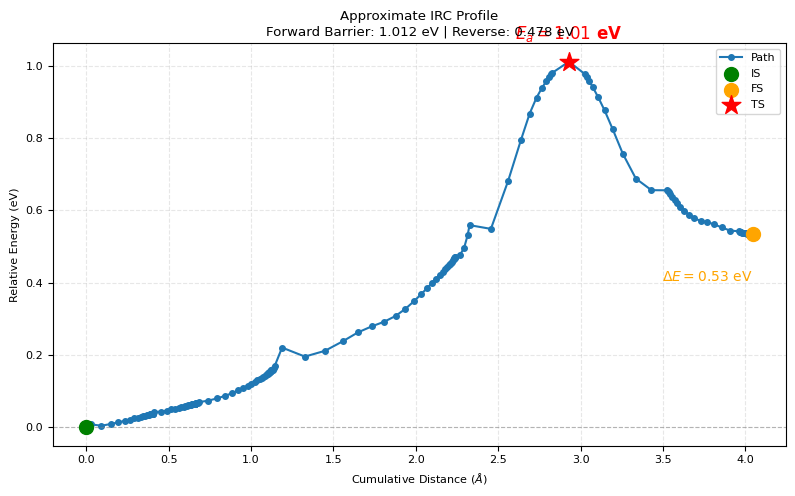

In [23]:
from shared import TSDescentOptimizer, get_vib_mode, plot_descent_profile
from ase.constraints import FixAtoms
# 1. Analyze Vibrations & Get Mode
os.chdir('/mnt/c/Users/user/Downloads/xtb')
mode = get_vib_mode(
    image_TS_initial1, 
    calculator=MACECalculator(
    model_paths='/mnt/d/Download/train-HCOTiRe_run-123_stagetwo.model',
    device='cuda',
    default_dtype='float32',
),   # 显式传入 Calculator
    constraint=FixAtoms([atom.index for atom in image_TS_initial1 if atom.symbol in ["Ti"]]),   # 显式传入 Constraint
    cutoff_cm=50.0,       # 过滤小于 50 cm^-1 的虚频
    output_all_imag_modes=True # 输出所有显著虚频的动画
)
if mode is not None:
    # 2. Run Fake-IRC Descent
    optimizer = TSDescentOptimizer(image_TS_initial1, mode, delta=0.1, log_prefix="irc_check")
    path = optimizer.run(fmax=0.05, steps=500)

    # 3. Plot Profile
    plot_descent_profile(path, title="Approximate IRC Profile", save_path="profile.png")

/root/miniforge3/envs/mace_les/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

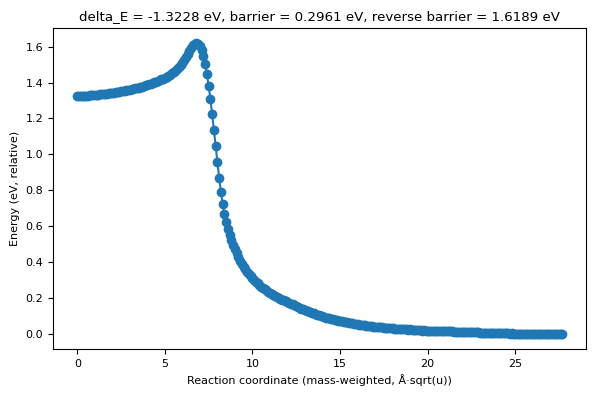

In [7]:
from shared import get_clean_irc_path, plot_irc
from ase.io import read

# 1. 准备 TS 结构 (需包含 Calculator)

# ts_atoms.calc = YourCalculator() # 确保挂载了计算器

# 2. 运行 Sella IRC
# 参数对应 Sella IRC 的配置: dx (步长), eta (容差), ninner_iter (内部迭代)
irc_path = get_clean_irc_path(
    image_TS_initial1, 
    irc_log_prefix="my_irc_run", 
    fmax=0.05, 
    steps=500, 
    dx=0.1, 
    eta=1e-4
)

if irc_path:
    print(f"IRC 成功，路径长度: {len(irc_path)}")
    
    # 3. 绘制能量曲线
    plot_irc(irc_path, title="My Reaction Profile")
else:
    print("IRC 失败 (Sella 可能未安装或未收敛)")

/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
use_amp: False


/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

/root/miniforge3/envs/mace_les/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

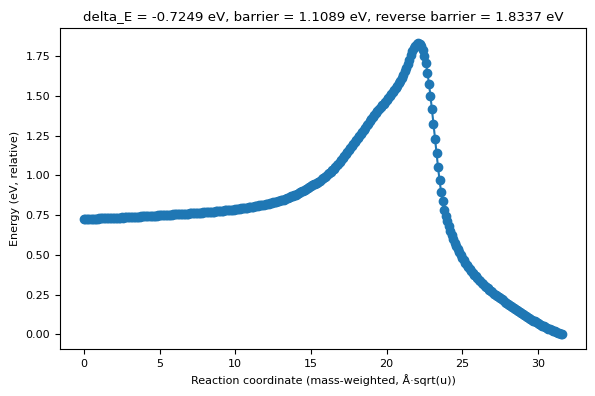

<Figure size 640x480 with 0 Axes>

In [14]:
from ase.constraints import FixAtoms
ase_vib(ts_atoms=image_TS_initial1, name='TS_initial2', constraint=FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.symbol in ['Si', 'O']]), CUTOFF=50, 
calc=MACECalculator(
    model_paths='/root/.cache/mace/mace-omat-0-small.model',
    device='cuda',
    default_dtype='float32',
)
)
full_path = get_clean_irc_path(ts_atoms=image_TS_initial1, irc_log_prefix="irc", fmax=0.05, steps=1000, dx=0.1, eta=1e-4, ninner_iter=100)
plot_irc(full_path, title="TS_initial2")


In [15]:
IS, FS = full_path[0], full_path[-1]
IS.write('IS.cif')
FS.write('FS.cif')


>>> [Vib-Check] Starting Hessian calculation for TS_initial1...
     Constraint applied.
use_amp: False


/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

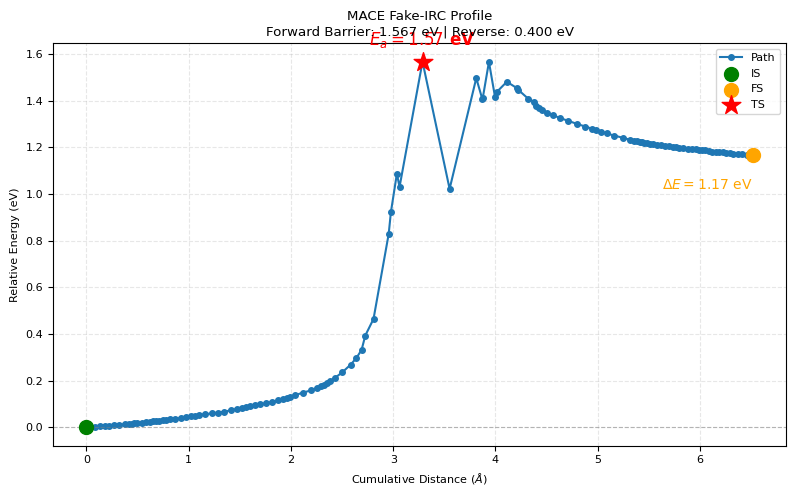

In [32]:
mode_vec = get_vib_mode(
                            image_TS_initial1, 
            constraint=FixAtoms(indices=[atom.index for atom in image_TS_initial1 if atom.symbol in ['Si', "O"]]),   # 传入约束
            name="TS_initial1", 
            cutoff_cm=50.0           # 忽略小于 20 cm^-1 的软模
)

# 4. 【Optimization 阶段】只有通过检查才执行
if mode_vec is not None:
    print("\n>>> Check passed! Starting Fake-IRC...")
    
    descent = TSDescentOptimizer(
        image_TS_initial1, 
        vib_mode=mode_vec,
        constraint=None,  # 优化时也要带上约束！
        delta=0.1,
        log_prefix="reaction_path"
    )
    
    # 推荐使用 LBFGS，它在下降任务中比 CG 更快
    path = descent.run(fmax=0.05, optimizer_cls=LBFGS)
    plot_descent_profile(
            path, 
            title="MACE Fake-IRC Profile", 
            save_path=f"TS_initial1_reaction_profile.png"
        )
else:
    print("\n>>> Check failed! Stopping workflow.")

In [12]:
image_TS_initial2 = read('/mnt/c/Users/user/Downloads/POSCAR_t')
image_TS_initial2.set_calculator(MACECalculator(
    model_paths='/root/.cache/mace/mace-omat-0-small.model',
    device='cuda',
    default_dtype='float32',
))
ccqn = CCQNOptimizerGPU(image_TS_initial2, reactive_bonds=[(23, 24), (24, 317)], e_vector_method='ic', cos_phi=0.3, logfile='ccqn_t.log', trajectory='ccqn_t.traj') 
ccqn.run(fmax=0.05, steps=500)

/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_9684/303346175.py:2: FutureWarning: Please use atoms.calc = calc
  image_TS_initial2.set_calculator(MACECalculator(
/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
u

True

/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
use_amp: False


/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

/root/miniforge3/envs/mace_les/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

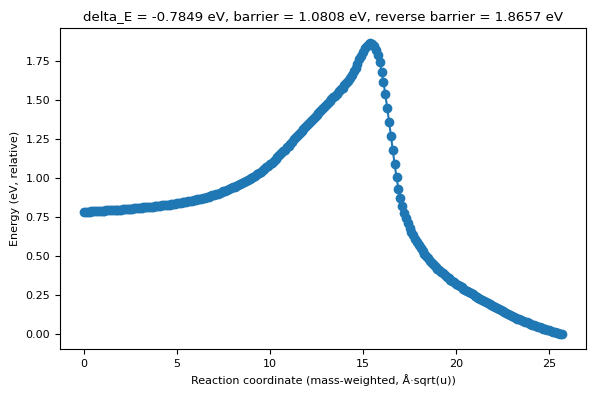

<Figure size 640x480 with 0 Axes>

In [34]:
ase_vib(ts_atoms=image_TS_initial2, name='TS_initial2', constraint=FixAtoms(indices=[atom.index for atom in image_TS_initial2 if atom.symbol in ['Si', 'O']]), CUTOFF=50, 
calc=MACECalculator(
    model_paths='/root/.cache/mace/mace-omat-0-small.model',
    device='cuda',
    default_dtype='float32',
)
)
full_path = get_clean_irc_path(ts_atoms=image_TS_initial2, irc_log_prefix="irc", fmax=0.05, steps=1000, dx=0.1, eta=1e-4, ninner_iter=100)
plot_irc(full_path, title="TS_initial2")



>>> [Vib-Check] Starting Hessian calculation for TS_initial2...
     Constraint FixAtoms(indices=[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 2

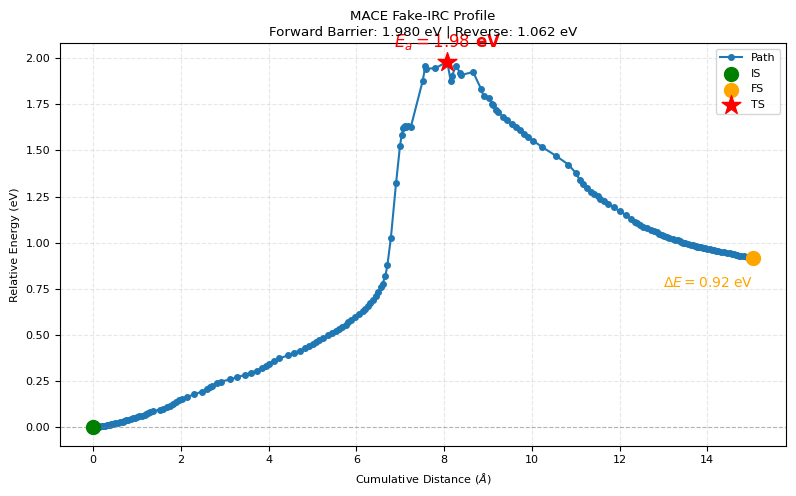

In [125]:
mode_vec = get_vib_mode(
            atoms, 
            constraint=FixAtoms(indices=[atom.index for atom in atoms if atom.symbol in ['Si', "O"]]),   # 传入约束
            name="TS_initial2", 
            cutoff_cm=50.0           # 忽略小于 50 cm^-1 的软模
)

# 4. 【Optimization 阶段】只有通过检查才执行
if mode_vec is not None:
    print("\n>>> Check passed! Starting Fake-IRC...")
    
    descent = TSDescentOptimizer(
        atoms, 
        vib_mode=mode_vec,
        constraint=None,  # 优化时也要带上约束！
        delta=0.1,
        log_prefix="atoms"
    )
    
    # 推荐使用 LBFGS，它在下降任务中比 CG 更快
    path = descent.run(fmax=0.05, optimizer_cls=LBFGS)
    plot_descent_profile(
            path, 
            title="MACE Fake-IRC Profile", 
            save_path=f"atoms.png"
        )
else:
    print("\n>>> Check failed! Stopping workflow.")

In [121]:
atoms

Atoms(symbols='C9H16AlCl3MgO194Si95Zn', pbc=True, cell=[20.07, 19.92, 13.42], constraint=FixInternals(_copy_init=['FixBondCombo(-0.07082363616085008, [[23, 24], [24, 317]], {self.coefs})'], epsilon=1e-07), calculator=MACECalculator(...))

In [46]:
from ase.build.surfaces_with_termination import translate_lattice
from ase.build.general_surface import surface
import numpy as np


def get_layers_z(atoms, tolerance=0.1):
    z = atoms.get_positions()[:, 2]
    keys = np.argsort(z)
    ikeys = np.argsort(keys)
    z_sorted = z[keys]
    mask = np.concatenate(([True], np.diff(z_sorted) > tolerance))
    tags_sorted = np.cumsum(mask) - 1
    tags = np.empty_like(tags_sorted)
    tags[ikeys] = tags_sorted
    return tags


def build_surface_exact(shifted_lattice, miller_indices, layers, vacuum, tol_layers=0.1, extra=3):
    surf = surface(shifted_lattice, miller_indices, layers=layers + extra, vacuum=None)
    tags = get_layers_z(surf, tolerance=tol_layers)
    k = tags.max() - (layers - 1)
    sel = [i for i, t in enumerate(tags) if t >= k]
    surf = surf[sel]
    surf.center(vacuum=vacuum, axis=2)
    return surf


def termination_signature_two_layers(surf, tol_layers=0.1):
    tags = get_layers_z(surf, tolerance=tol_layers)
    max_tag = tags.max()
    keep = {max_tag, max_tag - 1}
    idx = [i for i, t in enumerate(tags) if t in keep]
    syms = [surf.get_chemical_symbols()[i] for i in idx]
    return tuple(sorted(syms))


def get_all_terminations_two_layers(lattice, miller_indices, layers=2, vacuum=15.0, tol_layers=0.1):
    translated_lattices = translate_lattice(lattice, miller_indices)
    all_surfaces = []
    unique_terminations = {}
    for shifted in translated_lattices:
        surf = build_surface_exact(shifted, miller_indices, layers=layers, vacuum=vacuum, tol_layers=tol_layers)
        sig = termination_signature_two_layers(surf, tol_layers=tol_layers)
        unique_terminations[sig] = surf
        all_surfaces.append(surf)
    return all_surfaces, unique_terminations


if __name__ == "__main__":
    from ase.build import bulk
    from ase.io import read
    lat = read("../ZSM5.cif")
    surfaces, uniq = get_all_terminations_two_layers(lat, (1, 1, 0), layers=4, vacuum=15.0, tol_layers=0.1)
    print(len(surfaces), len(uniq))
    for k in uniq:
        print(k)


424 15
('O', 'Si', 'Si')
('Si', 'Si')
('O', 'Si')
('O', 'O', 'Si')
('O', 'O')
('O', 'O', 'O', 'Si')
('O', 'Si', 'Si', 'Si')
('O', 'O', 'Si', 'Si')
('O', 'O', 'O')
('O', 'O', 'O', 'O')
('Si', 'Si', 'Si')
('O', 'O', 'O', 'O', 'Si')
('O', 'O', 'Si', 'Si', 'Si')
('O', 'O', 'O', 'O', 'O', 'O', 'Si', 'Si', 'Si')
('O', 'O', 'O', 'Si', 'Si')


In [106]:
from ase.build.surfaces_with_termination import translate_lattice
from ase.build.general_surface import surface
from ase.geometry import get_layers
from ase.io import write
import numpy as np

def get_all_terminations(lattice, miller_indices, layers=1, vacuum=15.0):
    # 获取所有可能的平移
    translated_lattices = translate_lattice(lattice, miller_indices)
    #print(translated_lattices)
    all_surfaces = []
    unique_terminations = {}
    
    for shifted_lattice in translated_lattices:
        surf = surface(shifted_lattice, miller_indices, layers=layers, vacuum=vacuum)
        
        
        # 分析顶层原子组成
        z_layers, _ = get_layers(surf, (0, 0, 1))
        top_layer_indices = [i for i, layer in enumerate(z_layers) 
                           if (max(z_layers)-1) <= layer <= max(z_layers)]
        
        # 获取终端组成的指纹
        termination_signature = tuple(sorted([
            surf.get_chemical_symbols()[i] for i in top_layer_indices
        ]))
        
        # 去重：只保留独特的终端类型
        if termination_signature not in unique_terminations:
            unique_terminations[termination_signature] = surf
            all_surfaces.append(surf)
    
    return all_surfaces, unique_terminations

In [107]:

lat = read("../ZSM5.cif")
all_surfaces, unique_terminations = get_all_terminations(lat, (0,0,1), layers=1, vacuum=15.0)

In [6]:
# ssw_mace.py
import json
import math
import time
from dataclasses import dataclass, asdict, field
from typing import Optional, List, Dict, Any, Tuple

import numpy as np
from ase import Atoms
from ase.io import Trajectory, write
from ase.optimize import LBFGS
from ase.calculators.calculator import Calculator, all_changes

kB = 8.617333262145e-5  # eV/K


# -----------------------
# Utilities: projections
# -----------------------

def remove_translation_mode(N_flat: np.ndarray, natoms: int) -> np.ndarray:
    """Project out uniform translation in Cartesian space."""
    N = N_flat.reshape(natoms, 3).copy()
    t = N.mean(axis=0)
    N -= t[None, :]
    out = N.reshape(-1)
    nrm = np.linalg.norm(out)
    return out / (nrm + 1e-30)


def maybe_remove_rigid_motion(atoms: Atoms, N_flat: np.ndarray, remove_translation=True) -> np.ndarray:
    # Rotation removal for clusters is nontrivial and can conflict with PBC; default only translation.
    if remove_translation:
        return remove_translation_mode(N_flat, len(atoms))
    nrm = np.linalg.norm(N_flat)
    return N_flat / (nrm + 1e-30)


def mic_displacement(a: Atoms, i: int, j: int) -> np.ndarray:
    """Minimum-image displacement r_j - r_i (works only if cell exists sensibly)."""
    rij = a.get_positions()[j] - a.get_positions()[i]
    if a.get_pbc().any():
        # ASE has get_distances with mic, but we want vector. Use cell + scaled coords.
        cell = a.get_cell()
        if np.linalg.det(cell) == 0:
            return rij
        # fractional
        s = np.linalg.solve(cell.T, rij)
        s -= np.round(s)  # wrap to [-0.5, 0.5)
        rij = s @ cell
    return rij


# -----------------------
# Counting calculator
# -----------------------

class CountingCalculator(Calculator):
    """Wrap a base calculator and count calculate() calls (force/energy evaluations)."""
    implemented_properties = ["energy", "forces"]

    def __init__(self, base_calc: Calculator):
        super().__init__()
        self.base = base_calc
        self.ncalls_total = 0
        self.ncalls_step = 0

    def reset_step_counter(self):
        self.ncalls_step = 0

    def calculate(self, atoms=None, properties=("energy", "forces"), system_changes=all_changes):
        self.ncalls_total += 1
        self.ncalls_step += 1
        # delegate: temporarily set atoms.calc to base to avoid recursion
        super().calculate(atoms, properties, system_changes)
        atoms.calc = self.base
        E = atoms.get_potential_energy()
        F = atoms.get_forces()
        self.results["energy"] = E
        self.results["forces"] = F


# -----------------------
# Bias: Gaussians in s(R) = (R-Rref)·N
# -----------------------

def flatten_positions(atoms: Atoms) -> np.ndarray:
    return atoms.get_positions().reshape(-1).astype(float)


class GaussianBias:
    def __init__(self, N_flat: np.ndarray, s0: float, w: float, ds: float, R_ref_flat: np.ndarray):
        self.N = np.array(N_flat, dtype=float)
        self.s0 = float(s0)
        self.w = float(w)
        self.ds = float(ds)
        self.R_ref = np.array(R_ref_flat, dtype=float)

    def value_and_force_flat(self, R_flat: np.ndarray) -> Tuple[float, np.ndarray]:
        d = R_flat - self.R_ref
        s = float(np.dot(d, self.N))
        arg = (s - self.s0) / self.ds
        v = self.w * float(np.exp(-0.5 * arg * arg))
        dv_ds = v * (-(s - self.s0) / (self.ds * self.ds))
        F_flat = -dv_ds * self.N
        return v, F_flat


class BiasedCalculator(Calculator):
    implemented_properties = ["energy", "forces"]

    def __init__(self, base_calc: Calculator, biases: Optional[List[GaussianBias]] = None):
        super().__init__()
        self.base = base_calc
        self.biases = list(biases) if biases is not None else []

    def set_biases(self, biases: List[GaussianBias]):
        self.biases = list(biases)

    def clear_biases(self):
        self.biases = []

    def calculate(self, atoms=None, properties=("energy", "forces"), system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)
        atoms.calc = self.base
        E0 = atoms.get_potential_energy()
        F0 = atoms.get_forces()

        R_flat = flatten_positions(atoms)
        Eb = 0.0
        Fb_flat = np.zeros_like(R_flat)
        for b in self.biases:
            v, f = b.value_and_force_flat(R_flat)
            Eb += v
            Fb_flat += f

        self.results["energy"] = E0 + Eb
        self.results["forces"] = F0 + Fb_flat.reshape((-1, 3))


# -----------------------
# Modes: generators + refiners
# -----------------------

def random_global_mode(atoms: Atoms, rng: np.random.Generator, T=300.0) -> np.ndarray:
    # MB-like: v ~ N(0,1/sqrt(m)), normalization removes constants
    masses = atoms.get_masses()
    v = rng.normal(size=(len(atoms), 3)) / np.sqrt(masses[:, None])
    N = v.reshape(-1)
    N /= (np.linalg.norm(N) + 1e-30)
    return N


def random_bond_mode(atoms: Atoms, rng: np.random.Generator,
                     min_dist=3.0, max_tries=200) -> Tuple[np.ndarray, Optional[Dict[str, Any]]]:
    n = len(atoms)
    for _ in range(max_tries):
        i = int(rng.integers(0, n))
        j = int(rng.integers(0, n))
        if i == j:
            continue
        rij = mic_displacement(atoms, i, j)
        d = float(np.linalg.norm(rij))
        if d > min_dist:
            u = rij / d
            mode = np.zeros((n, 3))
            mode[i] = +u
            mode[j] = -u
            N = mode.reshape(-1)
            N /= (np.linalg.norm(N) + 1e-30)
            return N, {"type": "bond", "i": i, "j": j, "d": d}
    # fallback
    N = rng.normal(size=(n * 3,))
    N /= (np.linalg.norm(N) + 1e-30)
    return N, {"type": "bond_fallback"}


def mixed_mode(atoms: Atoms, rng: np.random.Generator,
               lam_range=(0.1, 1.5), min_dist=3.0,
               remove_translation=True) -> Tuple[np.ndarray, Dict[str, Any]]:
    Ng = random_global_mode(atoms, rng)
    Nl, meta = random_bond_mode(atoms, rng, min_dist=min_dist)
    lam = float(rng.uniform(*lam_range))
    N0 = lam * Ng + Nl
    N0 /= (np.linalg.norm(N0) + 1e-30)
    N0 = maybe_remove_rigid_motion(atoms, N0, remove_translation=remove_translation)
    return N0, {"lambda": lam, "local_meta": meta}


class DirectionRefiner:
    def refine(self, atoms: Atoms, N_flat: np.ndarray) -> np.ndarray:
        return N_flat


class ForceProjectionRefiner(DirectionRefiner):
    def __init__(self, eta=0.2, remove_translation=True):
        self.eta = float(eta)
        self.remove_translation = remove_translation

    def refine(self, atoms: Atoms, N_flat: np.ndarray) -> np.ndarray:
        F = atoms.get_forces().reshape(-1).astype(float)
        # perpendicular force component
        Fp = F - np.dot(F, N_flat) * N_flat
        nrm = np.linalg.norm(Fp)
        if nrm < 1e-12:
            N2 = N_flat
        else:
            N2 = N_flat + self.eta * (Fp / nrm)
        N2 /= (np.linalg.norm(N2) + 1e-30)
        N2 = maybe_remove_rigid_motion(atoms, N2, remove_translation=self.remove_translation)
        return N2


# -----------------------
# IO helpers
# -----------------------

class JSONLogger:
    def __init__(self, path: Optional[str]):
        self.path = path
        self._fh = open(path, "a", encoding="utf-8") if path else None

    def write(self, record: Dict[str, Any]):
        if not self._fh:
            return
        self._fh.write(json.dumps(record, ensure_ascii=False) + "\n")
        self._fh.flush()

    def close(self):
        if self._fh:
            self._fh.close()
            self._fh = None


class MinimaWriter:
    def __init__(self, path: Optional[str], mode="a"):
        self.path = path
        self.mode = mode
        self._initialized = False

    def write(self, atoms: Atoms, comment: str = ""):
        if not self.path:
            return
        # extended xyz appends; include energy in comment if present
        write(self.path, atoms, format="extxyz", append=True, comment=comment)
        self._initialized = True


# -----------------------
# SSW core
# -----------------------

@dataclass
class SSWParams:
    # core SSW
    ds: float = 0.40                # step length and Gaussian width scale (Å)
    H: int = 14                     # max number of Gaussians per MC step
    T_mc: float = 800.0             # Metropolis temperature (K)

    # adaptive Gaussian height
    w_init: float = 0.30            # initial guess (eV)
    w_min: float = 1e-4
    w_max: float = 5.0
    p_target: float = 0.10          # target (F_mod · N) in eV/Å at R_inf (heuristic)
    w_solve_max_iter: int = 25

    # mode generation/refine
    lam_range: Tuple[float, float] = (0.1, 1.5)
    local_mode_min_dist: float = 3.0
    remove_translation_mode: bool = True
    refiner: str = "forceproj"      # "none" or "forceproj"
    refine_eta: float = 0.20

    # optimizations
    climb_fmax: float = 0.08        # modified PES convergence (eV/Å)
    quench_fmax: float = 0.05       # real PES convergence
    climb_opt_steps: int = 80
    quench_opt_steps: int = 220

    # stopping
    stop_if_lower_than_start: bool = True

    # budgets
    force_eval_budget_per_mcstep: int = 1200  # HARD cap

    # output control
    write_traj: bool = True
    traj_path: str = "ssw.traj"
    traj_stride: int = 1            # write every N recorded frames
    write_minima: bool = True
    minima_path: str = "minima.xyz"
    write_json: bool = True
    json_path: str = "ssw.jsonl"

    # what to record in traj
    record_climb: bool = True
    record_quench: bool = True
    record_only_accepted_minima: bool = False


@dataclass
class SSWStepInfo:
    step: int
    accepted: bool
    E_start: float
    E_candidate: float
    E_end: float
    Emax_climb_real: float
    n_gaussians: int
    force_evals: int
    seconds: float
    meta: Dict[str, Any] = field(default_factory=dict)


class SSWRunner:
    def __init__(self, mace_calc: Calculator, params: SSWParams, seed: Optional[int] = None):
        # wrap with counter so we can budget force evals
        self.base = CountingCalculator(mace_calc)
        self.p = params
        self.rng = np.random.default_rng(seed)

        if self.p.refiner == "none":
            self.refiner = DirectionRefiner()
        elif self.p.refiner == "forceproj":
            self.refiner = ForceProjectionRefiner(
                eta=self.p.refine_eta,
                remove_translation=self.p.remove_translation_mode
            )
        else:
            raise ValueError(f"Unknown refiner: {self.p.refiner}")

        self.jsonlog = JSONLogger(self.p.json_path if self.p.write_json else None)
        self.min_writer = MinimaWriter(self.p.minima_path if self.p.write_minima else None)
        self.traj = Trajectory(self.p.traj_path, "w") if self.p.write_traj else None
        self._traj_count = 0

    def close(self):
        if self.traj:
            self.traj.close()
            self.traj = None
        self.jsonlog.close()

    def _budget_ok(self) -> bool:
        return self.base.ncalls_step < self.p.force_eval_budget_per_mcstep

    def _write_traj(self, atoms: Atoms, tag: str):
        if not self.traj:
            return
        if (self._traj_count % self.p.traj_stride) == 0:
            a = atoms.copy()
            a.info = dict(a.info)
            a.info["ssw_tag"] = tag
            a.info["ssw_force_evals_step"] = self.base.ncalls_step
            print(f"Writing traj: {tag} with {self.base.ncalls_step} force evals")
            self.traj.write(a)
        self._traj_count += 1

    def _optimize(self, atoms: Atoms, fmax: float, steps: int, tag_prefix: str):
        opt = LBFGS(atoms, logfile=None)
        # step-by-step run to enforce budget
        for k in range(steps):
            if not self._budget_ok():
                break
            opt.run(fmax=fmax, steps=1)
            if self.p.write_traj and ((tag_prefix == "climb" and self.p.record_climb) or
                                     (tag_prefix == "quench" and self.p.record_quench)):
                self._write_traj(atoms, f"{tag_prefix}_opt{k}")
            # early stop if converged: LBFGS.run(fmax, steps=1) doesn't expose; so check max force
            f = atoms.get_forces()
            if np.max(np.linalg.norm(f, axis=1)) <= fmax:
                break

    def _quench_real(self, atoms: Atoms):
        atoms.calc = self.base
        self._optimize(atoms, fmax=self.p.quench_fmax, steps=self.p.quench_opt_steps, tag_prefix="quench")
        return atoms

    def _relax_modified(self, atoms: Atoms, biased_calc: BiasedCalculator):
        atoms.calc = biased_calc
        self._optimize(atoms, fmax=self.p.climb_fmax, steps=self.p.climb_opt_steps, tag_prefix="climb")
        return atoms

    def _solve_w(self, atoms_at_Rinf: Atoms, N: np.ndarray, R_ref_flat: np.ndarray, s0: float, ds: float) -> float:
        """
        Choose w such that (F_real + F_gauss(w))·N = p_target at R_inf.
        Since F_gauss is linear in w, we can solve by 1D root find robustly.
        """
        # Real force projection at R_inf
        atoms_at_Rinf.calc = self.base
        _ = atoms_at_Rinf.get_potential_energy()
        F_real = atoms_at_Rinf.get_forces().reshape(-1).astype(float)
        proj_real = float(np.dot(F_real, N))

        # Compute coefficient: proj_bias_per_w = (F_gauss(w=1)·N)
        Rinf_flat = flatten_positions(atoms_at_Rinf)
        gb_unit = GaussianBias(N_flat=N, s0=s0, w=1.0, ds=ds, R_ref_flat=R_ref_flat)
        _, F_unit = gb_unit.value_and_force_flat(Rinf_flat)
        proj_unit = float(np.dot(F_unit, N))  # this can be ~0 if s ~= s0; then w is ill-defined

        target = self.p.p_target
        if abs(proj_unit) < 1e-10:
            # fallback: use w_init
            return float(np.clip(self.p.w_init, self.p.w_min, self.p.w_max))

        # Solve proj_real + w*proj_unit = target => w = (target - proj_real)/proj_unit
        w = (target - proj_real) / proj_unit
        if not np.isfinite(w):
            w = self.p.w_init

        # clip + if negative (would invert bias), fallback to small positive
        w = float(np.clip(w, self.p.w_min, self.p.w_max))
        return w

    def mc_step(self, atoms_in: Atoms, istep: int) -> Tuple[Atoms, SSWStepInfo]:
        t0 = time.time()
        self.base.reset_step_counter()

        # Start from quenched minimum on real PES
        atoms0 = atoms_in.copy()
        atoms0 = self._quench_real(atoms0)
        atoms0.calc = self.base
        E_start = float(atoms0.get_potential_energy())
        if self.p.write_traj:
            self._write_traj(atoms0, "start_min")

        # reference point for s(R)
        R_ref = flatten_positions(atoms0)

        # initial mode
        N, mode_meta = mixed_mode(
            atoms0, self.rng,
            lam_range=self.p.lam_range,
            min_dist=self.p.local_mode_min_dist,
            remove_translation=self.p.remove_translation_mode
        )

        biases: List[GaussianBias] = []
        biased_calc = BiasedCalculator(self.base, biases=biases)

        current = atoms0.copy()
        Emax_real = E_start

        # climbing with Gaussian additions
        for n in range(1, self.p.H + 1):
            if not self._budget_ok():
                break

            # refine direction using real forces at current
            current.calc = self.base
            _ = current.get_potential_energy()
            N = self.refiner.refine(current, N)

            # define gaussian center at current point (on current structure)
            R_flat = flatten_positions(current)
            s0 = float(np.dot(R_flat - R_ref, N))

            # choose w adaptively using a probe point R_inf = R + ds*N
            probe = current.copy()
            probe.set_positions((R_flat + self.p.ds * N).reshape((-1, 3)))
            w = self._solve_w(probe, N, R_ref, s0, self.p.ds)

            biases.append(GaussianBias(N_flat=N, s0=s0, w=w, ds=self.p.ds, R_ref_flat=R_ref))
            biased_calc.set_biases(biases)

            # take explicit step along N and relax on modified PES
            current.set_positions((R_flat + self.p.ds * N).reshape((-1, 3)))
            current = self._relax_modified(current, biased_calc)

            # track REAL energy maximum along climbing
            current.calc = self.base
            E_real = float(current.get_potential_energy())
            Emax_real = max(Emax_real, E_real)
            if self.p.write_traj and self.p.record_climb:
                self._write_traj(current, f"climb_min_n{n}")

            if self.p.stop_if_lower_than_start and (E_real < E_start):
                break

        n_gauss = len(biases)

        # remove bias and quench to real PES
        candidate = current.copy()
        candidate = self._quench_real(candidate)
        candidate.calc = self.base
        E_cand = float(candidate.get_potential_energy())
        if self.p.write_traj:
            self._write_traj(candidate, "candidate_min")

        # Metropolis
        if E_cand <= E_start:
            accept = True
        else:
            beta = 1.0 / (kB * self.p.T_mc)
            prob = math.exp(-(E_cand - E_start) * beta)
            accept = (float(self.rng.random()) < prob)

        if accept:
            atoms_next = candidate
            E_end = E_cand
        else:
            atoms_next = atoms0  # revert to starting min
            E_end = E_start

        # minima output
        if self.p.write_minima:
            if (not self.p.record_only_accepted_minima) or accept:
                tag = "accepted" if accept else "rejected"
                comment = f"ssw_step={istep} {tag} E={E_end:.6f} E_start={E_start:.6f} E_cand={E_cand:.6f} Emax={Emax_real:.6f}"
                self.min_writer.write(atoms_next, comment=comment)

        info = SSWStepInfo(
            step=istep,
            accepted=accept,
            E_start=E_start,
            E_candidate=E_cand,
            E_end=E_end,
            Emax_climb_real=Emax_real,
            n_gaussians=n_gauss,
            force_evals=int(self.base.ncalls_step),
            seconds=float(time.time() - t0),
            meta={
                "mode": mode_meta,
                "refiner": self.p.refiner,
                "params": {
                    "ds": self.p.ds, "H": self.p.H, "T_mc": self.p.T_mc,
                    "p_target": self.p.p_target
                }
            }
        )

        if self.p.write_json:
            self.jsonlog.write(asdict(info))

        return atoms_next, info

    def run(self, atoms0: Atoms, nsteps: int = 100, callback=None) -> Tuple[Atoms, List[SSWStepInfo]]:
        atoms = atoms0.copy()
        hist: List[SSWStepInfo] = []
        for i in range(nsteps):
            atoms, info = self.mc_step(atoms, i)
            hist.append(info)
            if callback:
                callback(atoms, info)
        return atoms, hist



In [13]:
# run_ssw_3exp.py
from pathlib import Path
from ase.io import read

# 确保从你定义 SSWParams/SSWRunner 的模块导入
# 如果就在同一个文件里，可省略这两行 import
# from your_module import SSWParams, SSWRunner


def run_experiment(name: str, atoms, mace_calc, params_kwargs: dict, nsteps: int = 200, seed: int = 0):
    outdir = Path(f"out_{name}")
    outdir.mkdir(parents=True, exist_ok=True)

    # 给每个实验独立输出文件，避免覆盖
    params_kwargs = dict(params_kwargs)  # copy
    params_kwargs.update({
        "traj_path": str(outdir / "ssw.traj"),
        "json_path": str(outdir / "ssw.jsonl"),
        "minima_path": str(outdir / "minima.xyz"),
        "write_traj": True,
        "write_json": True,
        "write_minima": True,
        "record_climb": True,
        "record_quench": True,
    })

    params = SSWParams(**params_kwargs)
    runner = SSWRunner(mace_calc=mace_calc, params=params, seed=seed)

    atoms_final, infos = runner.run(atoms0=atoms, nsteps=nsteps)

    # 可选：打印最后一步概况
    if infos:
        last = infos[-1]
        print(f"[{name}] steps={len(infos)} accepted_last={last.accepted} "
              f"E_end={last.E_end:.6f} json={params.json_path}")
    else:
        print(f"[{name}] no steps returned? json={params.json_path}")

    return atoms_final, infos


def main():
    # 1) 读入起始结构
    atoms0 = read("../POSCAR_t")  # 改成你的输入文件

    # 2) 准备你的 ASE calculator（变量名要叫 mace_calc 只是为了契合签名）
    # 例子（你自己替换）：
    # from mace.calculators import MACECalculator
    # mace_calc = MACECalculator(model_paths="mace.model", device="cuda", default_dtype="float32")
    mace_calc = MACECalculator(
        model_paths="/root/.cache/mace/mace-omat-0-small.model",
        device="cuda",            # GPU
        default_dtype="float32"
    )  # <- 替换成你的 calculator

    # 3) 基础参数（先保证 quench 更充分，避免“细碎降能”假象）
    base = dict(
        ds=0.4,
        H=14,
        T_mc=800.0,

        # 关键：你当前看到爬坡太弱/不爬坡，先做诊断：关 refiner
        refiner="forceproj",
        refine_eta=0.2,

        p_target=0.1,
        w_init=0.3,
        w_min=1e-4,
        w_max=5.0,
        w_solve_max_iter=25,

        lam_range=(0.1, 1.5),
        local_mode_min_dist=3.0,
        remove_translation_mode=True,

        climb_fmax=0.08,
        climb_opt_steps=80,

        # 建议：先更严格淬火，确保是真极小
        quench_fmax=0.02,
        quench_opt_steps=800,

        stop_if_lower_than_start=True,
        force_eval_budget_per_mcstep=1200,

        traj_stride=1,
        record_only_accepted_minima=False,
    )

    # ===== 实验 A：关 refiner（最关键诊断）=====
    run_experiment(
        name="A_refiner_none",
        atoms=atoms0.copy(),
        mace_calc=mace_calc,
        params_kwargs=(base | dict(refiner="none")),
        nsteps=200,
        seed=1,
    )

    # ===== 实验 B：增强偏置（提高 p_target）=====
    run_experiment(
        name="B_ptarget_0p2",
        atoms=atoms0.copy(),
        mace_calc=mace_calc,
        params_kwargs=(base | dict(refiner="none", p_target=0.2)),
        nsteps=200,
        seed=2,
    )

    # ===== 实验 C：更偏局部事件（表面/缺陷常更合理）=====
    run_experiment(
        name="C_local_modes",
        atoms=atoms0.copy(),
        mace_calc=mace_calc,
        params_kwargs=(base | dict(refiner="none", p_target=0.2, lam_range=(0.05, 0.7), local_mode_min_dist=2.6)),
        nsteps=200,
        seed=3,
    )

    print("Done. Compare out_*/ssw.jsonl, focus on (Emax_climb_real - E_start) and n_gaussians.")


if __name__ == "__main__":
    main()


/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
use_amp: False


/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: False
use_amp: F

KeyboardInterrupt: 

In [10]:

from ase.io import read
from mace.calculators import MACECalculator
#from ssw_mace import SSWRunner, SSWParams

atoms = read("../POSCAR_t")  # 你的初始结构（周期/非周期都可）

mace = MACECalculator(
    model_paths="/root/.cache/mace/mace-omat-0-small.model",
    device="cuda",            # GPU
    default_dtype="float32"
)
atoms.set_calculator(mace)
opt = LBFGS(atoms)
opt.run(fmax=0.05, steps=300)

params = SSWParams(
    # 预算（你提出要参数化）
    force_eval_budget_per_mcstep=1500,

    # 输出等级
    write_traj=True, traj_path="ssw2.traj", record_climb=True, record_quench=True,
    write_minima=True, minima_path="minima2.xyz",
    write_json=True, json_path="ssw2.jsonl",

    # 通用默认
    ds=0.40, H=14, T_mc=800.0,
)

runner = SSWRunner(mace, params, seed=42)
final_atoms, hist = runner.run(atoms, nsteps=10)
runner.close()

/root/bin/mace-0.3.14/mace/calculators/mace.py:199: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head omat_pbe out of ['omat_pbe']
Default dtype float32 does not match model dtype float64, converting models to float32.
Setting inference mode to: enable_amp = False
use_amp: False


/tmp/ipykernel_15432/3612783992.py:12: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(mace)
/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


       Step     Time          Energy          fmax
LBFGS:    0 00:38:57    -2434.545410        2.356714
use_amp: False
LBFGS:    1 00:38:57    -2434.773926        1.121251
use_amp: False
LBFGS:    2 00:38:57    -2434.909912        0.805899
use_amp: False
LBFGS:    3 00:38:57    -2435.032959        0.865043
use_amp: False
LBFGS:    4 00:38:57    -2435.162598        1.022732
use_amp: False
LBFGS:    5 00:38:57    -2435.280273        1.211503
use_amp: False
LBFGS:    6 00:38:57    -2435.365967        0.946775
use_amp: False
LBFGS:    7 00:38:57    -2435.457764        0.637769
use_amp: False
LBFGS:    8 00:38:57    -2435.504639        0.620610
use_amp: False
LBFGS:    9 00:38:58    -2435.548096        0.431715
use_amp: False
LBFGS:   10 00:38:58    -2435.574707        0.577628
use_amp: False
LBFGS:   11 00:38:58    -2435.608887        0.435589
use_amp: False
LBFGS:   12 00:38:58    -2435.648193        0.548295
use_amp: False
LBFGS:   13 00:38:58    -2435.699707        0.376043
use_amp: Fal

In [12]:
import inspect
print(SSWParams)
print(inspect.signature(SSWParams))
print(inspect.signature(SSWRunner.__init__))
print(inspect.signature(SSWRunner.run))

<class '__main__.SSWParams'>
(ds: float = 0.4, H: int = 14, T_mc: float = 800.0, w_init: float = 0.3, w_min: float = 0.0001, w_max: float = 5.0, p_target: float = 0.1, w_solve_max_iter: int = 25, lam_range: Tuple[float, float] = (0.1, 1.5), local_mode_min_dist: float = 3.0, remove_translation_mode: bool = True, refiner: str = 'forceproj', refine_eta: float = 0.2, climb_fmax: float = 0.08, quench_fmax: float = 0.05, climb_opt_steps: int = 80, quench_opt_steps: int = 220, stop_if_lower_than_start: bool = True, force_eval_budget_per_mcstep: int = 1200, write_traj: bool = True, traj_path: str = 'ssw.traj', traj_stride: int = 1, write_minima: bool = True, minima_path: str = 'minima.xyz', write_json: bool = True, json_path: str = 'ssw.jsonl', record_climb: bool = True, record_quench: bool = True, record_only_accepted_minima: bool = False) -> None
(self, mace_calc: ase.calculators.calculator.Calculator, params: __main__.SSWParams, seed: Optional[int] = None)
(self, atoms0: ase.atoms.Atoms, ns

In [109]:
from ase.visualize import view

write("ZSM5_surfaces.xyz", all_surfaces)
view(all_surfaces[1], viewer='x3d')

In [37]:
path[0].get_forces().min(), path[-1].get_forces().min()


(-0.03583008050918579, -0.03135515749454498)

In [119]:
image_TS_initial2.get_potential_energy()


use_amp: False


/root/bin/mace-0.3.14/mace/modules/models.py:509: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.bfloat16):


-2436.067626953125